In [8]:
import sys
import pickle
import torch
import pandas as pd
import xgboost as xgb
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
sys.path.append("..")

from torch.utils.data import DataLoader
from speechbrain.pretrained import EncoderClassifier
from src.coraa_dataset import CORAADataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix

with open("embeddings.pkl", "rb") as f:
    embeddings = pickle.load(f)

In [5]:
DATA_DIR = "../data/train/"
dataset = CORAADataset(DATA_DIR, model_sr=16000)

print(f"There are {len(dataset)} samples!")

dataloader = DataLoader(dataset)

There are 625 samples!


In [6]:
X = torch.cat(embeddings).squeeze(dim=1).detach().numpy()
le = preprocessing.LabelEncoder()
y = le.fit_transform(dataset.labels)

In [9]:
pd.value_counts(dataset.labels)

neutral               491
non-neutral-female     89
non-neutral-male       45
dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [11]:
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [12]:
le.classes_

array(['neutral', 'non-neutral-female', 'non-neutral-male'], dtype='<U18')

In [13]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test)

In [14]:
params = {
    'max_depth': 5,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 3,
    # Set number of GPUs if available   
    'n_gpus': 0
}

In [15]:
bst = xgb.train(params, dtrain)

[22:35:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [16]:
pred = bst.predict(dtest)
pred

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 2., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32)

In [17]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       123
           1       0.17      0.09      0.11        23
           2       0.20      0.09      0.13        11

    accuracy                           0.75       157
   macro avg       0.39      0.37      0.37       157
weighted avg       0.68      0.75      0.70       157



In [18]:
cm = confusion_matrix(y_test, pred)
cm

array([[114,   7,   2],
       [ 19,   2,   2],
       [  7,   3,   1]])

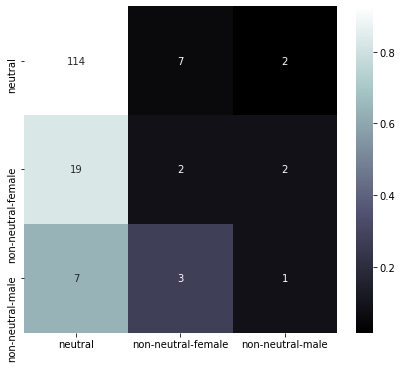

In [19]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

plot_confusion_matrix(cm, le.classes_)